<a href="https://colab.research.google.com/github/kingnathan-15/Recommender-Project/blob/main/Anime_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset Import


In [36]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("CooperUnion/anime-recommendations-database")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'anime-recommendations-database' dataset.
Path to dataset files: /kaggle/input/anime-recommendations-database


In [60]:
import urllib.request
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt # Corrected import

In [38]:
csv_path = path + '/rating.csv'
rating_df = pd.read_csv(csv_path)
anime_path = path + '/anime.csv'
anime_df = pd.read_csv(anime_path)

In [39]:
from sklearn.preprocessing import MultiLabelBinarizer

# Split genres into lists
anime_df['genre_list'] = anime_df['genre'].fillna('').apply(lambda x: [g.strip() for g in x.split(',')])

# Convert genres into binary features
mlb = MultiLabelBinarizer()
genre_features = pd.DataFrame(mlb.fit_transform(anime_df['genre_list']),
                              columns=mlb.classes_,
                              index=anime_df.index)

# Combine with other features (optional)
new_df = pd.concat([anime_df[['anime_id', 'rating', 'members']], genre_features.fillna(0)], axis=1)

In [40]:
new_df.head()

,anime_id,rating,members,,Action,Adventure,Cars,Comedy,Dementia,Demons,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,32281,9.37,200630,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,5114,9.26,793665,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,28977,9.25,114262,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9253,9.17,673572,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,9969,9.16,151266,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')
anime_df['episodes'] = anime_df['episodes'].fillna(0).astype(int)
anime_df.sort_values('episodes')

,anime_id,name,genre,type,episodes,rating,members,genre_list
615,1735,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,0,7.94,533578,"[Action, Comedy, Martial Arts, Shounen, Super ..."
991,966,Crayon Shin-chan,"Comedy, Ecchi, Kids, School, Shounen, Slice of...",TV,0,7.73,26267,"[Comedy, Ecchi, Kids, School, Shounen, Slice o..."
1021,33157,Tanaka-kun wa Itsumo Kedaruge Specials,"Comedy, School, Slice of Life",Special,0,7.72,5400,"[Comedy, School, Slice of Life]"
1272,21639,Yu☆Gi☆Oh! Arc-V,"Action, Fantasy, Game, Shounen",TV,0,7.61,17571,"[Action, Fantasy, Game, Shounen]"
1309,8687,Doraemon (2005),"Comedy, Kids, Sci-Fi, Shounen",TV,0,7.59,2980,"[Comedy, Kids, Sci-Fi, Shounen]"
...,...,...,...,...,...,...,...,...
6580,8213,Hoka Hoka Kazoku,Comedy,TV,1428,6.05,194,[Comedy]
5360,6277,Manga Nippon Mukashibanashi (1976),"Fantasy, Historical",TV,1471,6.48,406,"[Fantasy, Historical]"
9243,23349,Kirin Monoshiri Yakata,Kids,TV,1565,5.56,116,[Kids]
929,2471,Doraemon (1979),"Adventure, Comedy, Fantasy, Kids, Sci-Fi, Shounen",TV,1787,7.76,14233,"[Adventure, Comedy, Fantasy, Kids, Sci-Fi, Sho..."


##Exploratory Data Analysis

###Univariate Exploration

In [42]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   anime_id    12294 non-null  int64  
 1   name        12294 non-null  object 
 2   genre       12232 non-null  object 
 3   type        12269 non-null  object 
 4   episodes    12294 non-null  int64  
 5   rating      12064 non-null  float64
 6   members     12294 non-null  int64  
 7   genre_list  12294 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 768.5+ KB


<Axes: xlabel='rating', ylabel='Count'>

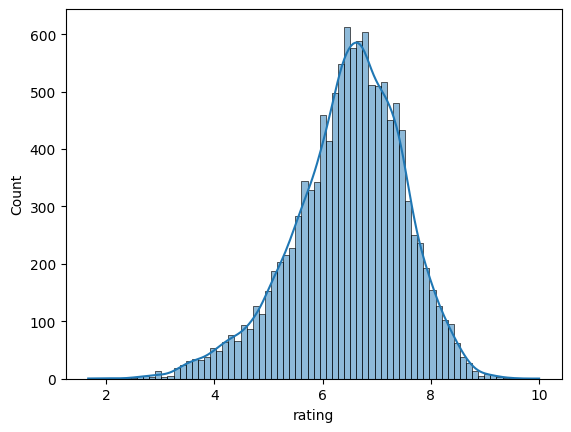

In [43]:
sns.histplot(x=new_df['rating'], data=new_df, kde=True)

<Axes: xlabel='episodes', ylabel='Density'>

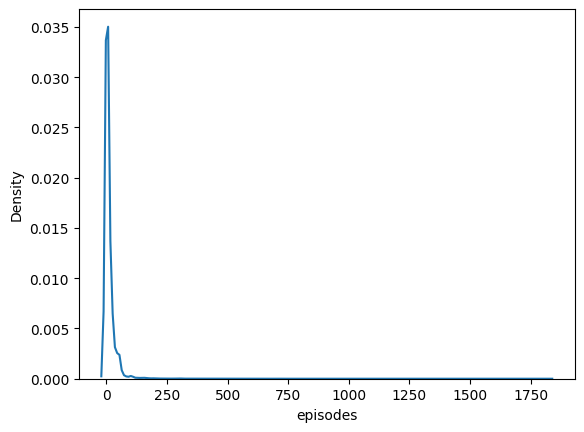

In [55]:
sns.kdeplot(x=anime_df['episodes'], data=new_df)

###Bivariate Exploration

<Axes: xlabel='episodes', ylabel='rating'>

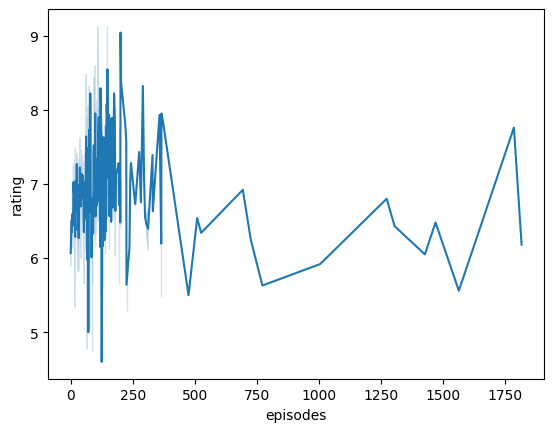

In [48]:
sns.lineplot(y=anime_df['rating'], x=anime_df['episodes'], data=anime_df)

<Axes: xlabel='rating', ylabel='members'>

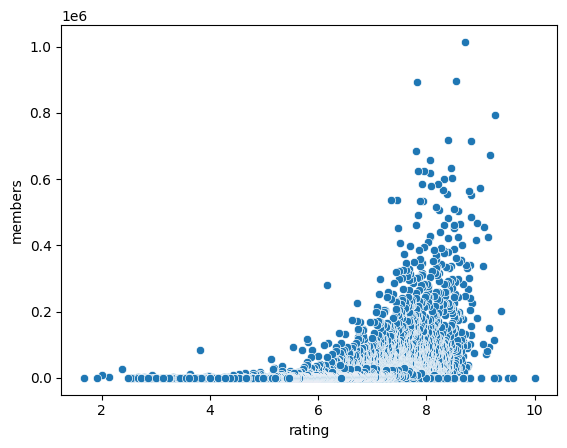

In [49]:
sns.scatterplot(y=new_df['members'], x=new_df['rating'], data=new_df)

In [58]:
genre_stats = []
for genre in genre_features.columns:
    genre_anime = new_df[new_df[genre] == 1]
    if len(genre_anime) > 0:  # Only include genres with data
        genre_stats.append({
            'genre': genre,
            'avg_rating': genre_anime['rating'].mean(),
            'count': len(genre_anime),
            'total_members': genre_anime['members'].sum()
        })

genre_stats_df = pd.DataFrame(genre_stats)

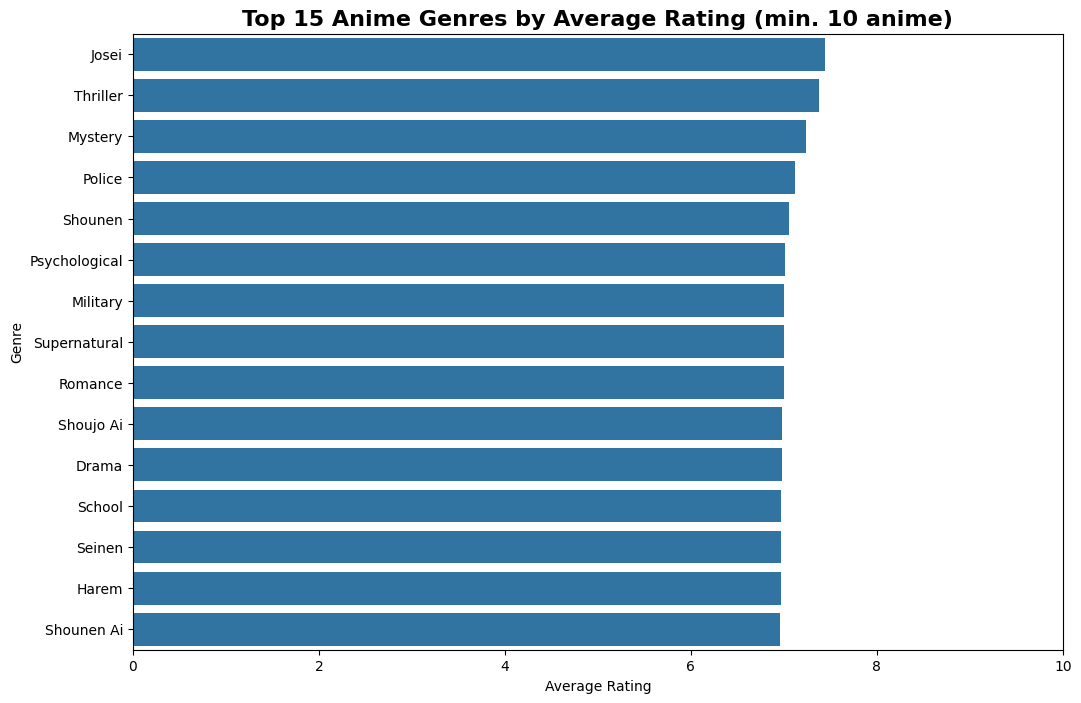

In [69]:
top_genres = genre_stats_df[genre_stats_df['count'] >= 10].nlargest(15, 'avg_rating')

plt.figure(figsize=(12, 8))
sns.barplot(data=top_genres, y='genre', x='avg_rating')

plt.title('Top 15 Anime Genres by Average Rating (min. 10 anime)', fontsize=16, fontweight='bold')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.xlim(0, 10)
plt.show()

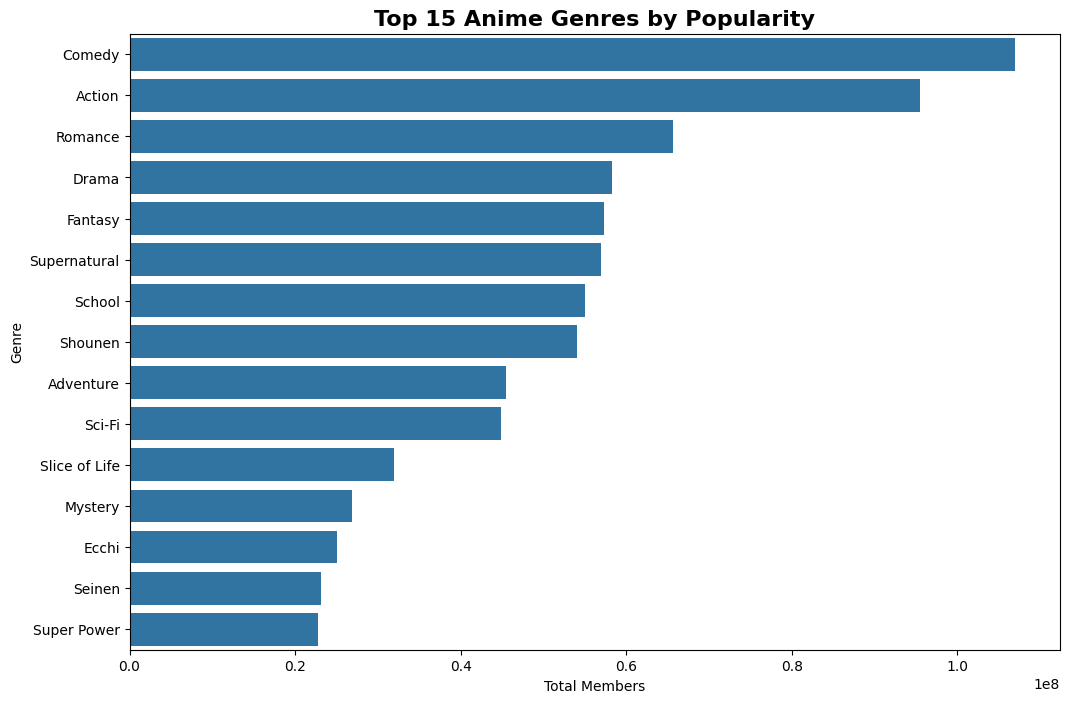

In [73]:
top_genres = genre_stats_df[genre_stats_df['count'] >= 10].nlargest(15, 'total_members')

plt.figure(figsize=(12, 8))
sns.barplot(data=top_genres, y='genre', x='total_members')

plt.title('Top 15 Anime Genres by Popularity', fontsize=16, fontweight='bold')
plt.xlabel('Total Members')
plt.ylabel('Genre')
plt.show()

###Multivariate Exploration

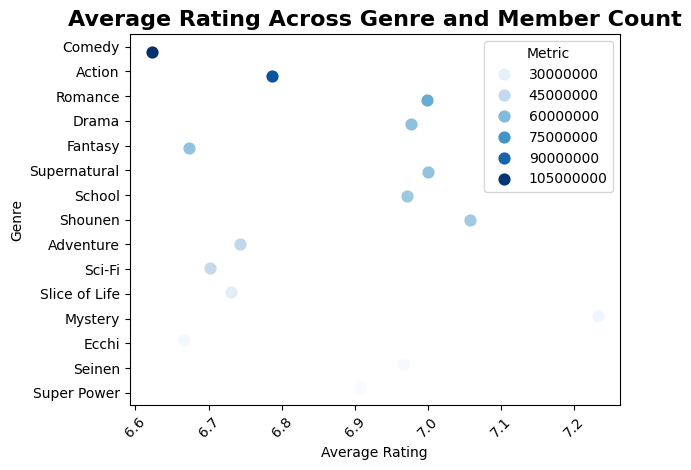

In [81]:
top_genres = genre_stats_df[genre_stats_df['count'] >= 10].nlargest(15, 'total_members')

plt.title('Average Rating Across Genre and Member Count', fontsize=16, fontweight='bold')
sns.pointplot(data = top_genres, x = 'avg_rating', y = 'genre', hue = 'total_members',
           palette = 'Blues', linestyles = '', dodge = 0.4)
plt.ylabel('Genre')
plt.xlabel('Average Rating')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show();

##Model Creation

In [ ]:
# merged_df = pd.merge(rating_df, new_df, on='anime_id', how='left')
# merged_df.head()

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC